In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import joblib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor


warnings.filterwarnings('ignore', module='sklearn')
pd.set_option('display.max_rows', 20)

from helpers import plot_y_yhat, create_random_submission, create_submission, calculate_rmse_error_over_time, plot_trajectories

/Users/corneliuswiehl/miniforge3/envs/sdc/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Split in specific runs

Split Dataframe in runs that start from t=0 to t=10

In [8]:
x_test_real = pd.read_csv("mlNOVA/mlNOVA/X_test.csv")
x_train = pd.read_csv("mlNOVA/mlNOVA/X_train.csv")

x_test_real.reset_index(drop=True, inplace=True)
x_train.reset_index(drop=True, inplace=True)

x_test_real["TRAJECTORY ID"] = 0
x_train["TRAJECTORY ID"] = 0

for i in range(0, len(x_test_real), 257):
    x_test_real.loc[i, "TRAJECTORY ID"] = 1
for i in range(0, len(x_train), 257):
    x_train.loc[i, "TRAJECTORY ID"] = 1

x_test_real["TRAJECTORY ID"] = x_test_real["TRAJECTORY ID"].astype(int).cumsum()
x_train["TRAJECTORY ID"] = x_train["TRAJECTORY ID"].astype(int).cumsum()

x_train["t"] = np.maximum(0.0, x_train["t"])
x_test_real["t"] = np.maximum(0.0, x_test_real["t"])

# rename columns of x_test_real x0_1,y0_1,x0_2,y0_2,x0_3,y0_3
x_test_real.columns = x_test_real.columns.str.replace(r'0_', '_')

We can see that all SETs are of length 257

In [9]:
vals = x_train.groupby("TRAJECTORY ID").size()
sets_not_257 = len(vals[vals != 257])
print(f"Number of sets with length != 257: {sets_not_257}")

Number of sets with length != 257: 0


#### Clean the trajectories after collisions

We do this in order to make the dataset easier to learn

In [10]:
x_train = x_train[~((x_train["t"]==0.0) & (x_train["x_1"]==0.0) & (x_train["y_1"]==0.0) & (x_train["x_2"]==0.0) & (x_train["y_2"]==0.0) & (x_train["x_3"]==0.0) & (x_train["y_3"]==0.0))]

#### Visualize one trajectory

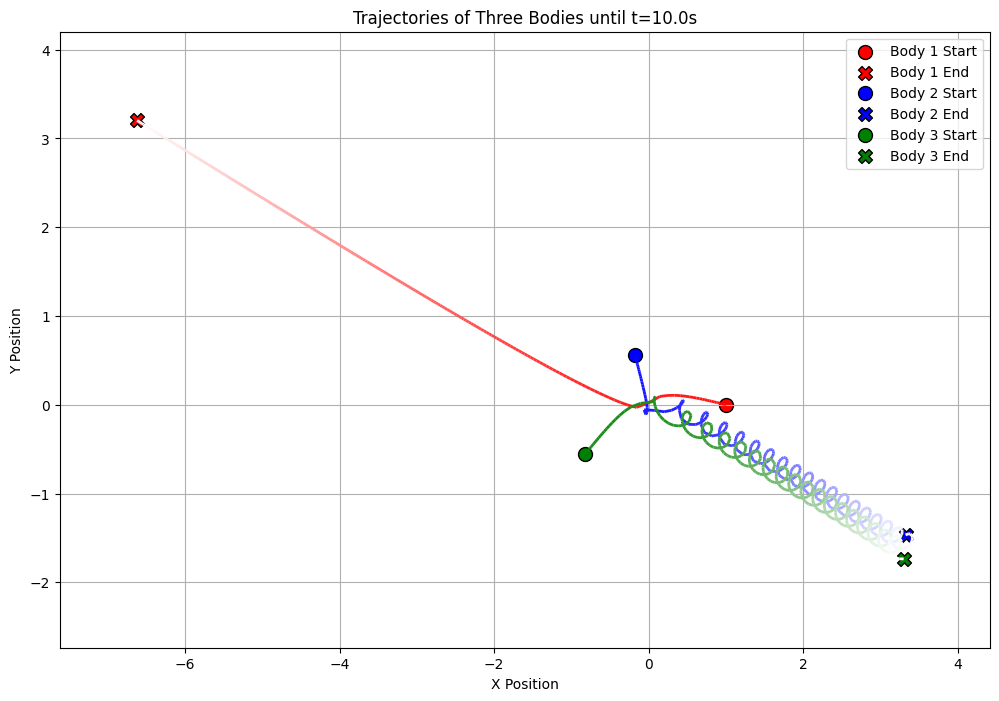

In [109]:
plot_trajectories(x_train[x_train["TRAJECTORY ID"]==2], max_time=10.0)

# Random Submission before Baseline

Create a random submission to see how such a model performs

In [12]:
tmp_random = create_random_submission("random_submission.csv")

# Task 1: Setting the Baseline

## Task 1.1 Data Preparation and Validation Pipeline

In [13]:
def generate_complete_dataset_one_df(data, max_delta_t=None):
    """ Generates Training data for one set"""
    n = len(data)
    
    # Create matrices for all combinations of rows
    i, j = np.triu_indices(n, k=1)
    
    # Extract the columns we need
    cols = ['x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2', 'x_3', 'y_3', 'v_x_3', 'v_y_3']
    
    # Create x_train_data
    x_train_data = data[cols].values[i]
    
    # Create y_train_data
    y_train_data = data[cols].values[j]
    
    # Calculate delta_t
    t_initial = data['t'].values[i]
    t_future = data['t'].values[j]
    delta_t = np.maximum(t_future - t_initial,0)
    
    # Create DataFrames
    x_train_df = pd.DataFrame(x_train_data, columns=cols)
    y_train_df = pd.DataFrame(y_train_data, columns=cols)
    
    # Add delta_t to x_train_df
    x_train_df['t'] = delta_t
    # remove all with delta_t > max_delta_t
    if max_delta_t is not None:
        x_train_df = x_train_df[x_train_df['t'] <= max_delta_t]
        y_train_df = y_train_df.loc[x_train_df.index]
    
    return x_train_df, y_train_df

def generate_complete_dataset(data, max_delta_t=None):
    """ Generates Training data for all sets"""
    X = []
    y = []
    sets = data['TRAJECTORY ID'].unique()
    for s in sets:
        X_s, y_s = generate_complete_dataset_one_df(data[data['TRAJECTORY ID'] == s], max_delta_t)
        X_s['TRAJECTORY ID'] = s
        y_s['TRAJECTORY ID'] = s
        X.append(X_s)
        y.append(y_s)

    X = pd.concat(X)
    y = pd.concat(y)

    return X, y


def generate_dataset_one_df(df):
    columns = df.columns.tolist()  # Convert to list once
    df_values = df.values  # Convert DataFrame to numpy array for faster access
    
    X = []
    y = []
    
    i = 0
    for j in range(i + 1, len(df_values)):
        delta_t = df_values[j][0] - df_values[i][0]  # Assuming 't' is the first column
        x_row = df_values[i][1:].tolist() + [delta_t]  # Skip 't' column in x_row
        y_row = df_values[j][1:].tolist()  # Skip 't' column in y_row
        
        X.append(x_row)
        y.append(y_row)
    
    # Create DataFrames at the end
    columns_x = columns[1:] + ['t']  # Exclude 't' and add 'delta_t'
    X = pd.DataFrame(X, columns=columns_x)
    y = pd.DataFrame(y, columns=columns[1:])  # Exclude 't'

    return X, y

def generate_dataset(df):
    # for each TRAJECTORY ID create a dataset and concat them
    X = []
    y = []
    sets = df['TRAJECTORY ID'].unique()
    for s in sets:
        X_s, y_s = generate_dataset_one_df(df[df['TRAJECTORY ID'] == s])
        # add information about TRAJECTORY ID to the dataset
        X_s['TRAJECTORY ID'] = s
        y_s['TRAJECTORY ID'] = s
        X.append(X_s)
        y.append(y_s)

    X = pd.concat(X)
    y = pd.concat(y)


    return X, y

#### Generate full training data

In [14]:
X_data, y_data = generate_dataset(x_train)

print(X_data.shape)

X_data.head()

(1084792, 15)


,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id,TRAJECTORY ID,t
0,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0.0,1,0.039062
1,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0.0,1,0.078125
2,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0.0,1,0.117188
3,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0.0,1,0.156250
4,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0,0.0,1,0.195312


#### Create train and test split

Here we want to split the trajectories in train, validation and test set. We want data samples from **one** trajectory only in **one** of train, validation and test set. 

We also apply the scaling to the data by fitting the scaler to the train sets and applying them to the others such that all models use the same data and scaler.

In [15]:
x_columns_train = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3','v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3','t']
y_columns_train = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3','v_x_1','v_y_1','v_x_2','v_y_2','v_x_3','v_y_3']
x_columns_submissions = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
def create_train_val_test_splits(X_data, y_data, x_columns_train, y_columns_train, random_state=42):
    x_columns = X_data.columns.tolist()
    y_columns = y_data.columns.tolist()


    # Get the unique TRAJECTORY IDs (trajectories)
    set_ids = X_data['TRAJECTORY ID'].unique()

    # Split the TRAJECTORY IDs into train+val and test (e.g., 90% train+val, 10% test)
    set_ids_train_val, set_ids_test = train_test_split(set_ids, test_size=0.1, random_state=random_state)

    # Now split the train+val TRAJECTORY IDs into train and validation sets (e.g., 75% train, 25% val)
    set_ids_train, set_ids_val = train_test_split(set_ids_train_val, test_size=0.25, random_state=random_state)
    # This gives 60% train, 20% validation, and 20% test

    # Now, select the rows from X_data and y_data based on the TRAJECTORY IDs
    X_train = X_data[X_data['TRAJECTORY ID'].isin(set_ids_train)].reset_index(drop=True)
    X_val = X_data[X_data['TRAJECTORY ID'].isin(set_ids_val)].reset_index(drop=True)
    X_test = X_data[X_data['TRAJECTORY ID'].isin(set_ids_test)].reset_index(drop=True)

    y_train = y_data[y_data['TRAJECTORY ID'].isin(set_ids_train)].reset_index(drop=True)
    y_val= y_data[y_data['TRAJECTORY ID'].isin(set_ids_val)].reset_index(drop=True)
    y_test= y_data[y_data['TRAJECTORY ID'].isin(set_ids_test)].reset_index(drop=True)

    X_train = X_train[x_columns_train]
    X_val = X_val[x_columns_train]
    X_test = X_test[x_columns_train]

    y_train = y_train[y_columns_train]
    y_val = y_val[y_columns_train]
    y_test = y_test[y_columns_train]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [16]:
X_train, X_val, X_test, y_train, y_val, y_test = create_train_val_test_splits(X_data, y_data, x_columns_train, y_columns_train)

In [61]:
def train_model(model, X_train, y_train, X_val, y_val, X_test, y_test, x_columns_train, y_columns_train):

    results = {}

    model.fit(X_train[x_columns_train], y_train[y_columns_train])
    train_err = model.score(X_train[x_columns_train], y_train[y_columns_train])
    val_err = model.score(X_val[x_columns_train], y_val[y_columns_train])
    test_err = model.score(X_test[x_columns_train], y_test[y_columns_train])

    print(f"Train score: {train_err:.4f}")
    print(f"Validation score: {val_err:.4f}")
    print(f"Test score: {test_err:.4f}")
    results["train_score"] = train_err
    results["val_score"] = val_err
    results["test_score"] = test_err

    y_train_pred = model.predict(X_train[x_columns_train])
    y_val_pred = model.predict(X_val[x_columns_train])
    y_test_pred = model.predict(X_test[x_columns_train])

    # create dataframes
    y_train_pred = pd.DataFrame(y_train_pred, columns=y_columns_train)
    y_val_pred = pd.DataFrame(y_val_pred, columns=y_columns_train)
    y_test_pred = pd.DataFrame(y_test_pred, columns=y_columns_train)

    # caluclate the RMSE only for the columns that are in y_columns_train
    train_rmse = np.sqrt(mean_squared_error(y_train[y_columns_train], y_train_pred[y_columns_train]))
    val_rmse = np.sqrt(mean_squared_error(y_val[y_columns_train], y_val_pred[y_columns_train]))
    test_rmse = np.sqrt(mean_squared_error(y_test[y_columns_train], y_test_pred[y_columns_train]))
    results["train_rmse"] = train_rmse
    results["val_rmse"] = val_rmse
    results["test_rmse"] = test_rmse

    try:
        rmse_over_time = calculate_rmse_error_over_time(X_val, y_val, model, x_columns_train, y_columns_train)
        results["rmse_over_time"] = rmse_over_time
    except:
        print("Could not calculate rmse over time")
        pass
    return y_train_pred, y_val_pred, y_test_pred, model, results


## Task 1.2 Learn the baseline model

#### Complete baseline model

In [18]:
from sklearn.linear_model import LinearRegression

baseline_model = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('regressor', LinearRegression())  
])

y_train_pred, y_val_pred, y_test_pred, baseline_model, baseline_results= train_model(baseline_model, X_train, y_train, X_val, y_val, X_test, y_test, x_columns_train, y_columns_train)


Train score: 0.0548
Validation score: 0.0587
Test score: 0.0500


#### Note

We can see that the RMSE is higher on the validation data and model performs not very good.

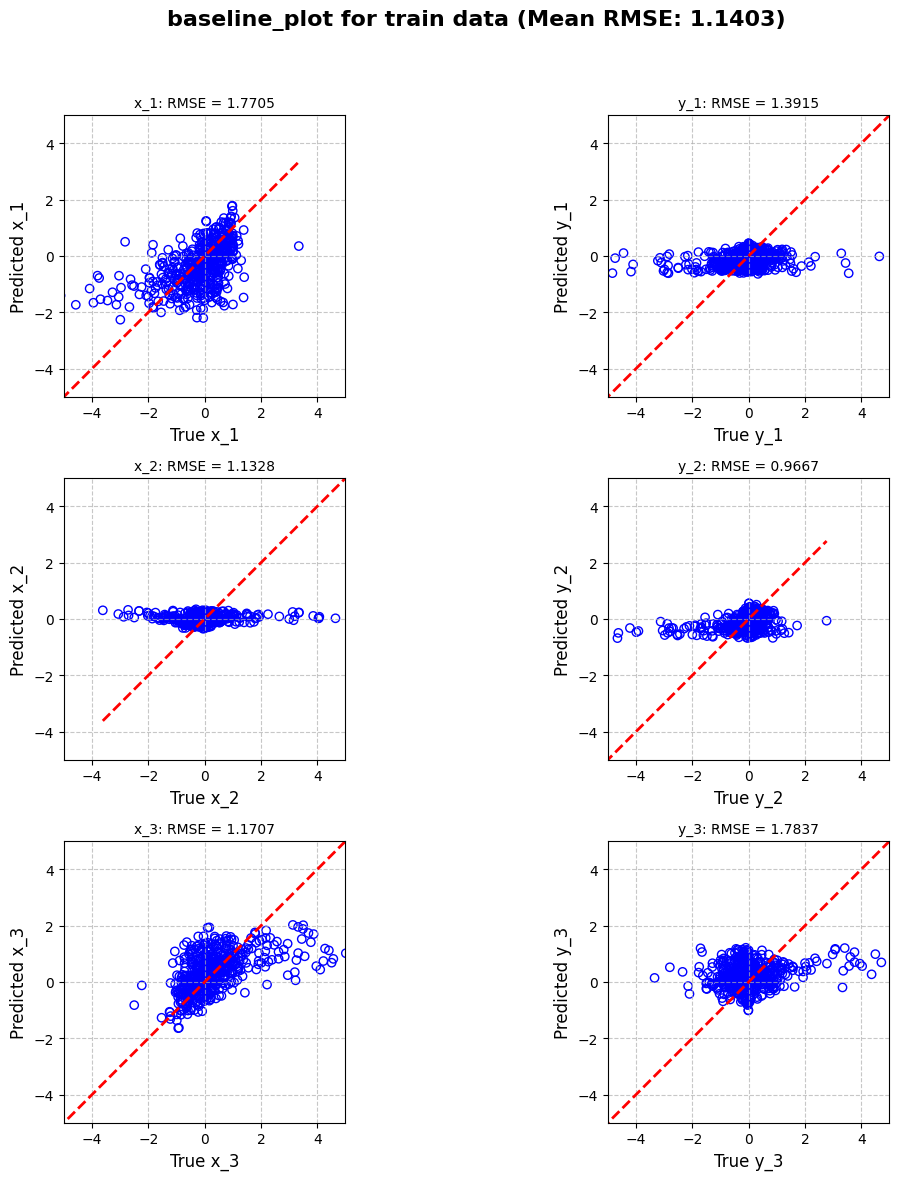

In [19]:
plot_y_yhat(y_train[y_columns_train], y_train_pred, plot_title="baseline_plot for train data")

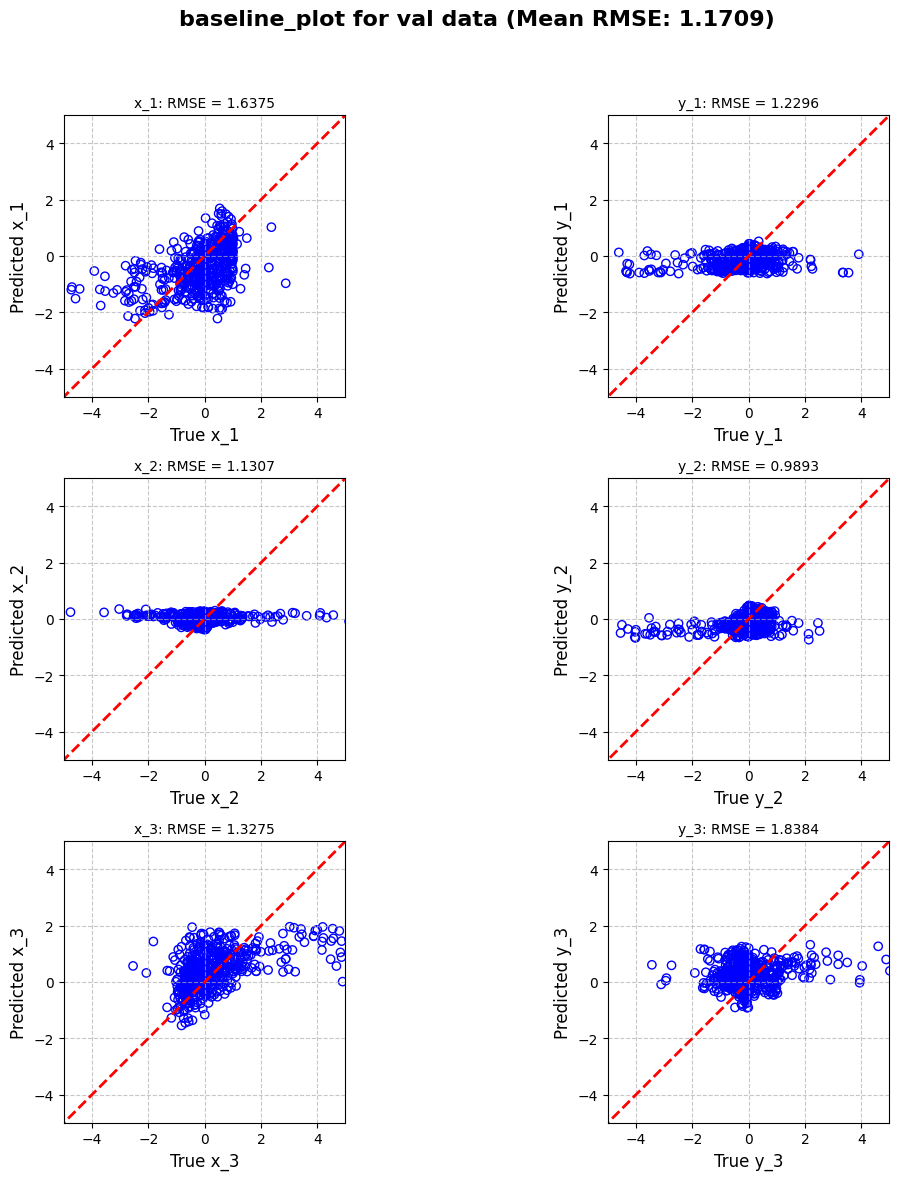

In [20]:
plot_y_yhat(y_val[y_columns_train], y_val_pred, plot_title="baseline_plot for val data")

#### Create submission for baseline

In [21]:
_ = create_submission(baseline_model, "submission_baseline.csv", x_test_real, x_columns_train, y_columns_train, x_columns_submissions)

# Task 2 Nonlinear models on the data — the Polynomial Regression model

# Task 2.1 Development

First we validate our polynomial model. We try to find the best degree and regularization strength with a sample of the data

In [22]:
def validate_poly_regression(X_train, y_train, X_val, y_val, degrees=range(1, 15), alphas=[1.0], x_columns_train=x_columns_train, y_columns_train=y_columns_train):
    best_rmse = float('inf')
    best_model = None
    best_degree = None
    best_alpha = None
    feature_counts = []
    rmses_val = []
    rmses_train = []

    # create df to save all results
    results = pd.DataFrame(columns=["degree", "alpha", "features", "rmse_train", "rmse_val"])

    X_train = X_train[x_columns_train]
    X_val = X_val[x_columns_train]

    y_train = y_train[y_columns_train]
    y_val = y_val[y_columns_train]

    
    for degree in degrees:
        
        # Iterate over the list of alpha values for Ridge regularization
        for alpha_value in alphas:
            regressor = Ridge(alpha=alpha_value) 
            
            # Create a pipeline to combine polynomial feature generation and the regression model
            model = Pipeline(steps=[
                ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
                ('scaler', StandardScaler()),
                ('regressor', regressor)
            ])
            
            # Train the model
            model.fit(X_train, y_train)

            # Predict on train data
            y_pred_train = model.predict(X_train)

            # Calculate RMSE
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            rmses_train.append(rmse_train)
            
            # Predict on validation data
            y_pred = model.predict(X_val)
            
            # Calculate RMSE
            rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
            rmses_val.append(rmse_val)
            
            # Store the number of features generated
            feature_counts.append(model.named_steps['poly'].n_output_features_)
            
            print(f"Degree: {degree}, Alpha: {alpha_value}, Features: {model.named_steps['poly'].n_output_features_}, RMSE: {rmse_val}")
            # save results to the dataframe (with concat)
            results = pd.concat([results, pd.DataFrame([[degree, alpha_value, model.named_steps['poly'].n_output_features_, rmse_train, rmse_val]], columns=["degree", "alpha", "features", "rmse_train", "rmse_val"])])

            # Update the best model if this is the best RMSE so far
            if rmse_val < best_rmse:
                best_rmse = rmse_val
                best_model = model
                best_degree = degree
                best_alpha = alpha_value

    return best_model, best_rmse, best_degree, best_alpha, rmses_val, feature_counts, results

In [23]:
alphas = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0] # regularization strength
size_for_validation = 2000
random_state = 42
(
    best_model,
    best_rmse,
    best_degree,
    best_alpha,
    rmses,
    feature_counts,
    polynomial_validation_results,
) = validate_poly_regression(
    X_train.sample(size_for_validation, random_state=random_state),
    y_train.sample(size_for_validation, random_state=random_state),
    X_val.sample(size_for_validation, random_state=random_state),
    y_val.sample(size_for_validation, random_state=random_state),
    degrees=range(1, 5),
    alphas=alphas,
)

print(
    f"Best degree: {best_degree}, Best RMSE: {best_rmse}",
    f"Best alpha: {best_alpha}",
    f"Number of features: {best_model.named_steps['poly'].n_output_features_}",
)

Degree: 1, Alpha: 0.01, Features: 13, RMSE: 1.1954687998764095
Degree: 1, Alpha: 0.05, Features: 13, RMSE: 1.1954691245613638
Degree: 1, Alpha: 0.1, Features: 13, RMSE: 1.1954695304380334
Degree: 1, Alpha: 0.2, Features: 13, RMSE: 1.1954703422596147
Degree: 1, Alpha: 0.5, Features: 13, RMSE: 1.1954727782699763
Degree: 1, Alpha: 1.0, Features: 13, RMSE: 1.195476840103952
Degree: 1, Alpha: 2.0, Features: 13, RMSE: 1.1954849705693769
Degree: 1, Alpha: 5.0, Features: 13, RMSE: 1.1955094160430633
Degree: 1, Alpha: 10.0, Features: 13, RMSE: 1.1955503367560745
Degree: 1, Alpha: 20.0, Features: 13, RMSE: 1.1956328318540843
Degree: 1, Alpha: 50.0, Features: 13, RMSE: 1.1958852613371271
Degree: 2, Alpha: 0.01, Features: 104, RMSE: 1.1703607165332128
Degree: 2, Alpha: 0.05, Features: 104, RMSE: 1.1703601956439669
Degree: 2, Alpha: 0.1, Features: 104, RMSE: 1.1703595468273793
Degree: 2, Alpha: 0.2, Features: 104, RMSE: 1.1703582568251658
Degree: 2, Alpha: 0.5, Features: 104, RMSE: 1.17035444750951

#### Note

We analyze the difference between train and validation rmse to detect potential overfitting. If the difference is too high, we might have overfitting. We can also analyze the number of features generated by the polynomial features. If the number of features is too high, we might have an higher risk of overfitting.

We see in the table below that models with higher degree have a higher discrepancy in train and validation performance. Which makes sense since they are more prune to overfitting.

In [24]:
polynomial_validation_results["Difference train and val rmse"] = np.abs(polynomial_validation_results["rmse_train"] - polynomial_validation_results["rmse_val"])
polynomial_validation_results.sort_values(by="rmse_val").head(10)

,degree,alpha,features,rmse_train,rmse_val,Difference train and val rmse
0,4,0.10,2379,1.065440,1.096968,0.031528
0,4,0.20,2379,1.065665,1.096991,0.031326
0,4,0.05,2379,1.065347,1.097014,0.031667
0,4,0.01,2379,1.065303,1.097111,0.031808
0,4,0.50,2379,1.066362,1.097399,0.031037
0,4,1.00,2379,1.067470,1.098481,0.031011
0,4,2.00,2379,1.069427,1.100923,0.031496
0,4,5.00,2379,1.073535,1.106814,0.033279
0,4,10.00,2379,1.077319,1.112525,0.035206
0,4,20.00,2379,1.080954,1.118072,0.037118


#### Note

We can see in the table below that the larger the regularization strength the smaller the difference between train and validation performance. Such behaviour is expetced since the regularization can prevent overfitting on the train set. However the differences are minimal.

In [25]:
polynomial_validation_results.groupby("alpha")[["Difference train and val rmse"]].mean()

,Difference train and val rmse
alpha,
0.01,0.047932
0.05,0.047898
0.10,0.047865
0.20,0.047817
0.50,0.047753
1.00,0.047761
2.00,0.047911
5.00,0.048445
10.00,0.049075


#### Create best polynomial model

In [26]:
# Create polynomial features
model_polynomial = Pipeline(
    steps=[
        ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(alpha=best_alpha)),
    ]
)


y_pred_train_poly, y_pred_val_poly, y_pred_test_poly, model_polynomial, polynomial_results = train_model(
    model_polynomial,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    x_columns_train,
    y_columns_train,
)

Train score: 0.1299
Validation score: 0.1460
Test score: 0.1038


#### Explore Model

We can see from the graphs below that the RMSE of train and validation set is much more similar compared to the baseline model indicating a better generalization by the polynomial model

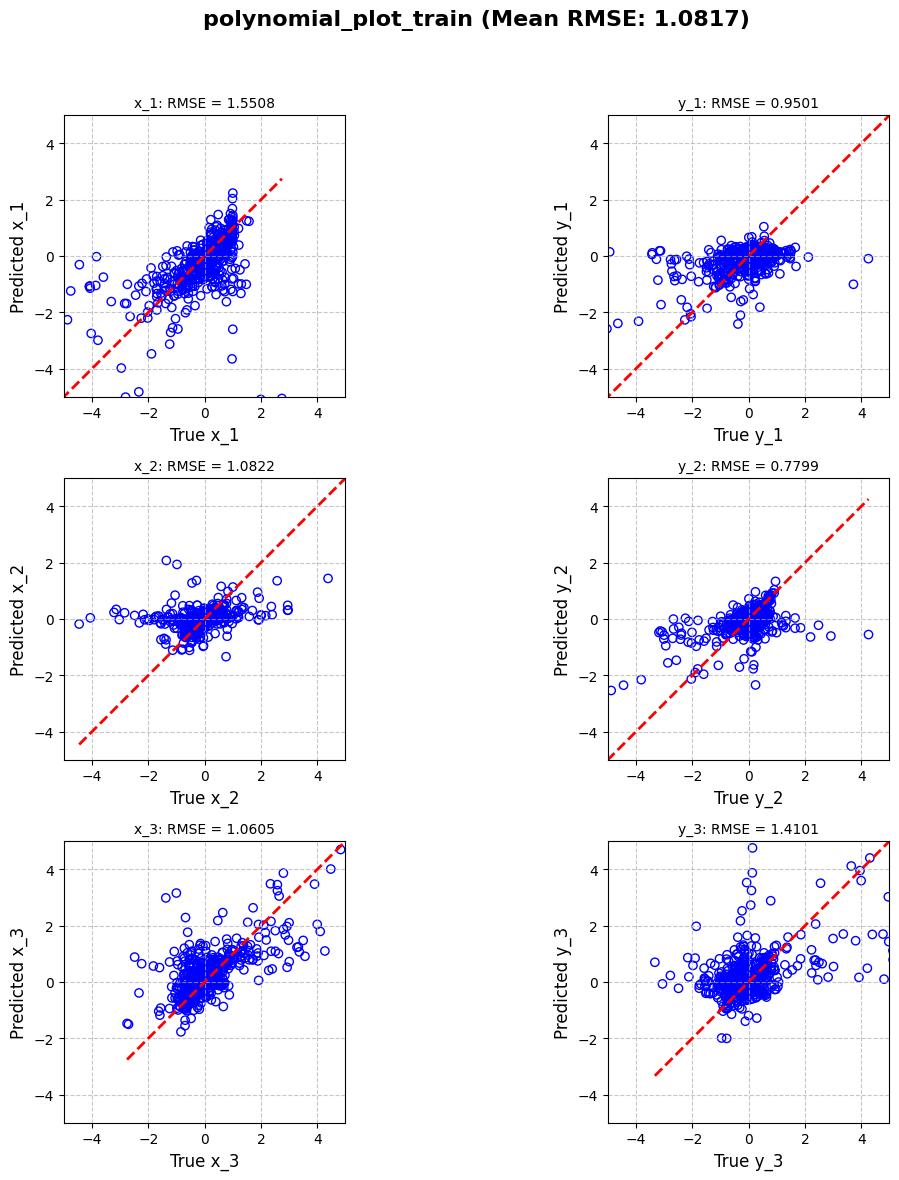

In [27]:
plot_y_yhat(y_train[y_columns_train], y_pred_train_poly, plot_title="polynomial_plot_train")

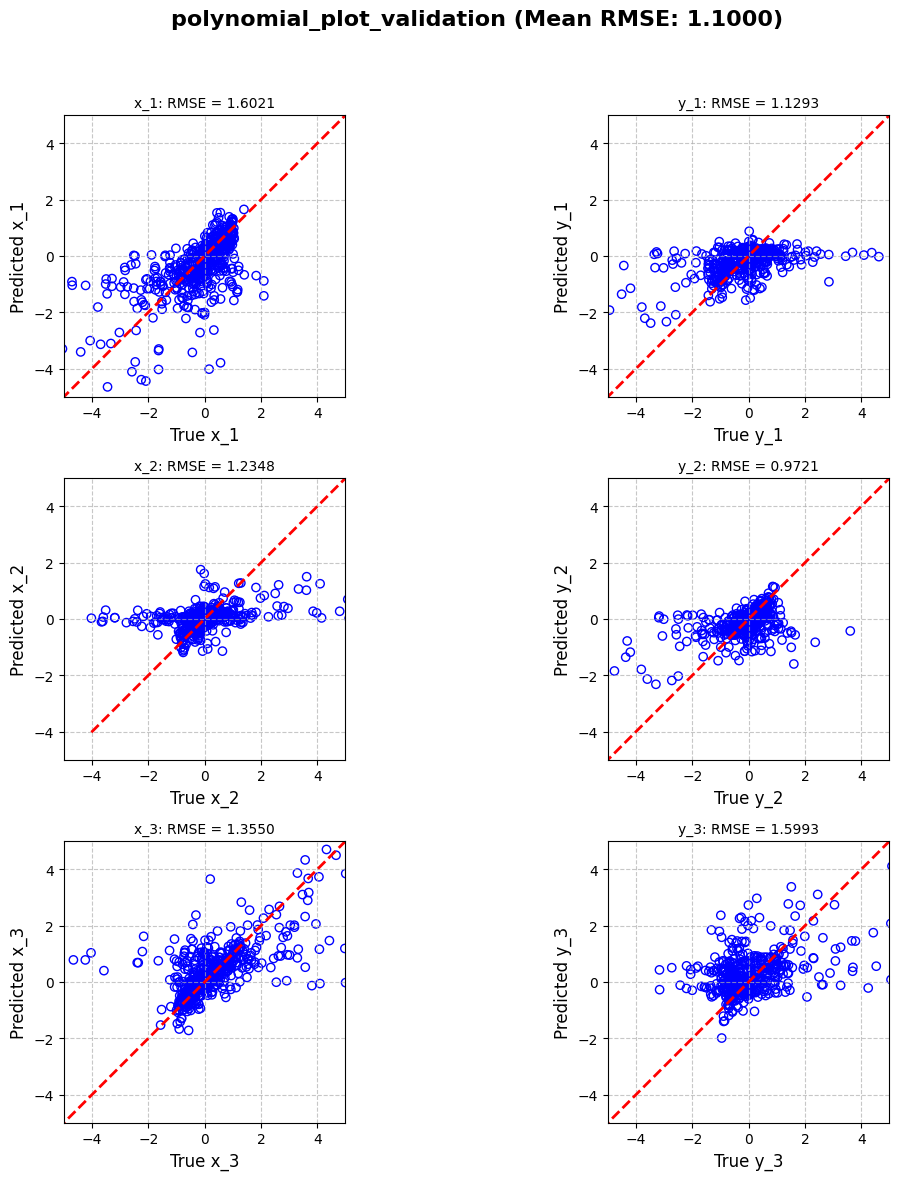

In [28]:
plot_y_yhat(y_val[y_columns_train], y_pred_val_poly, plot_title="polynomial_plot_validation")

#### create submission

In [29]:
_ = create_submission(model_polynomial, "polynomial_submission.csv", x_test_real, x_columns_train, y_columns_train, x_columns_submissions)

# Task 3 Feature Engineering

## Task 3.1 Removing variables

First analyze the variables used in the data. The sns pairplot helps you visualize correlations between features and identify redundant ones for feature reduction. The diagonal of a pairplot shows the univariate distribution (histogram or kernel density estimate) of each feature. The histogramm of the y_2 variable seems a little bit skewed indicating for a possible inbalance in the training data.

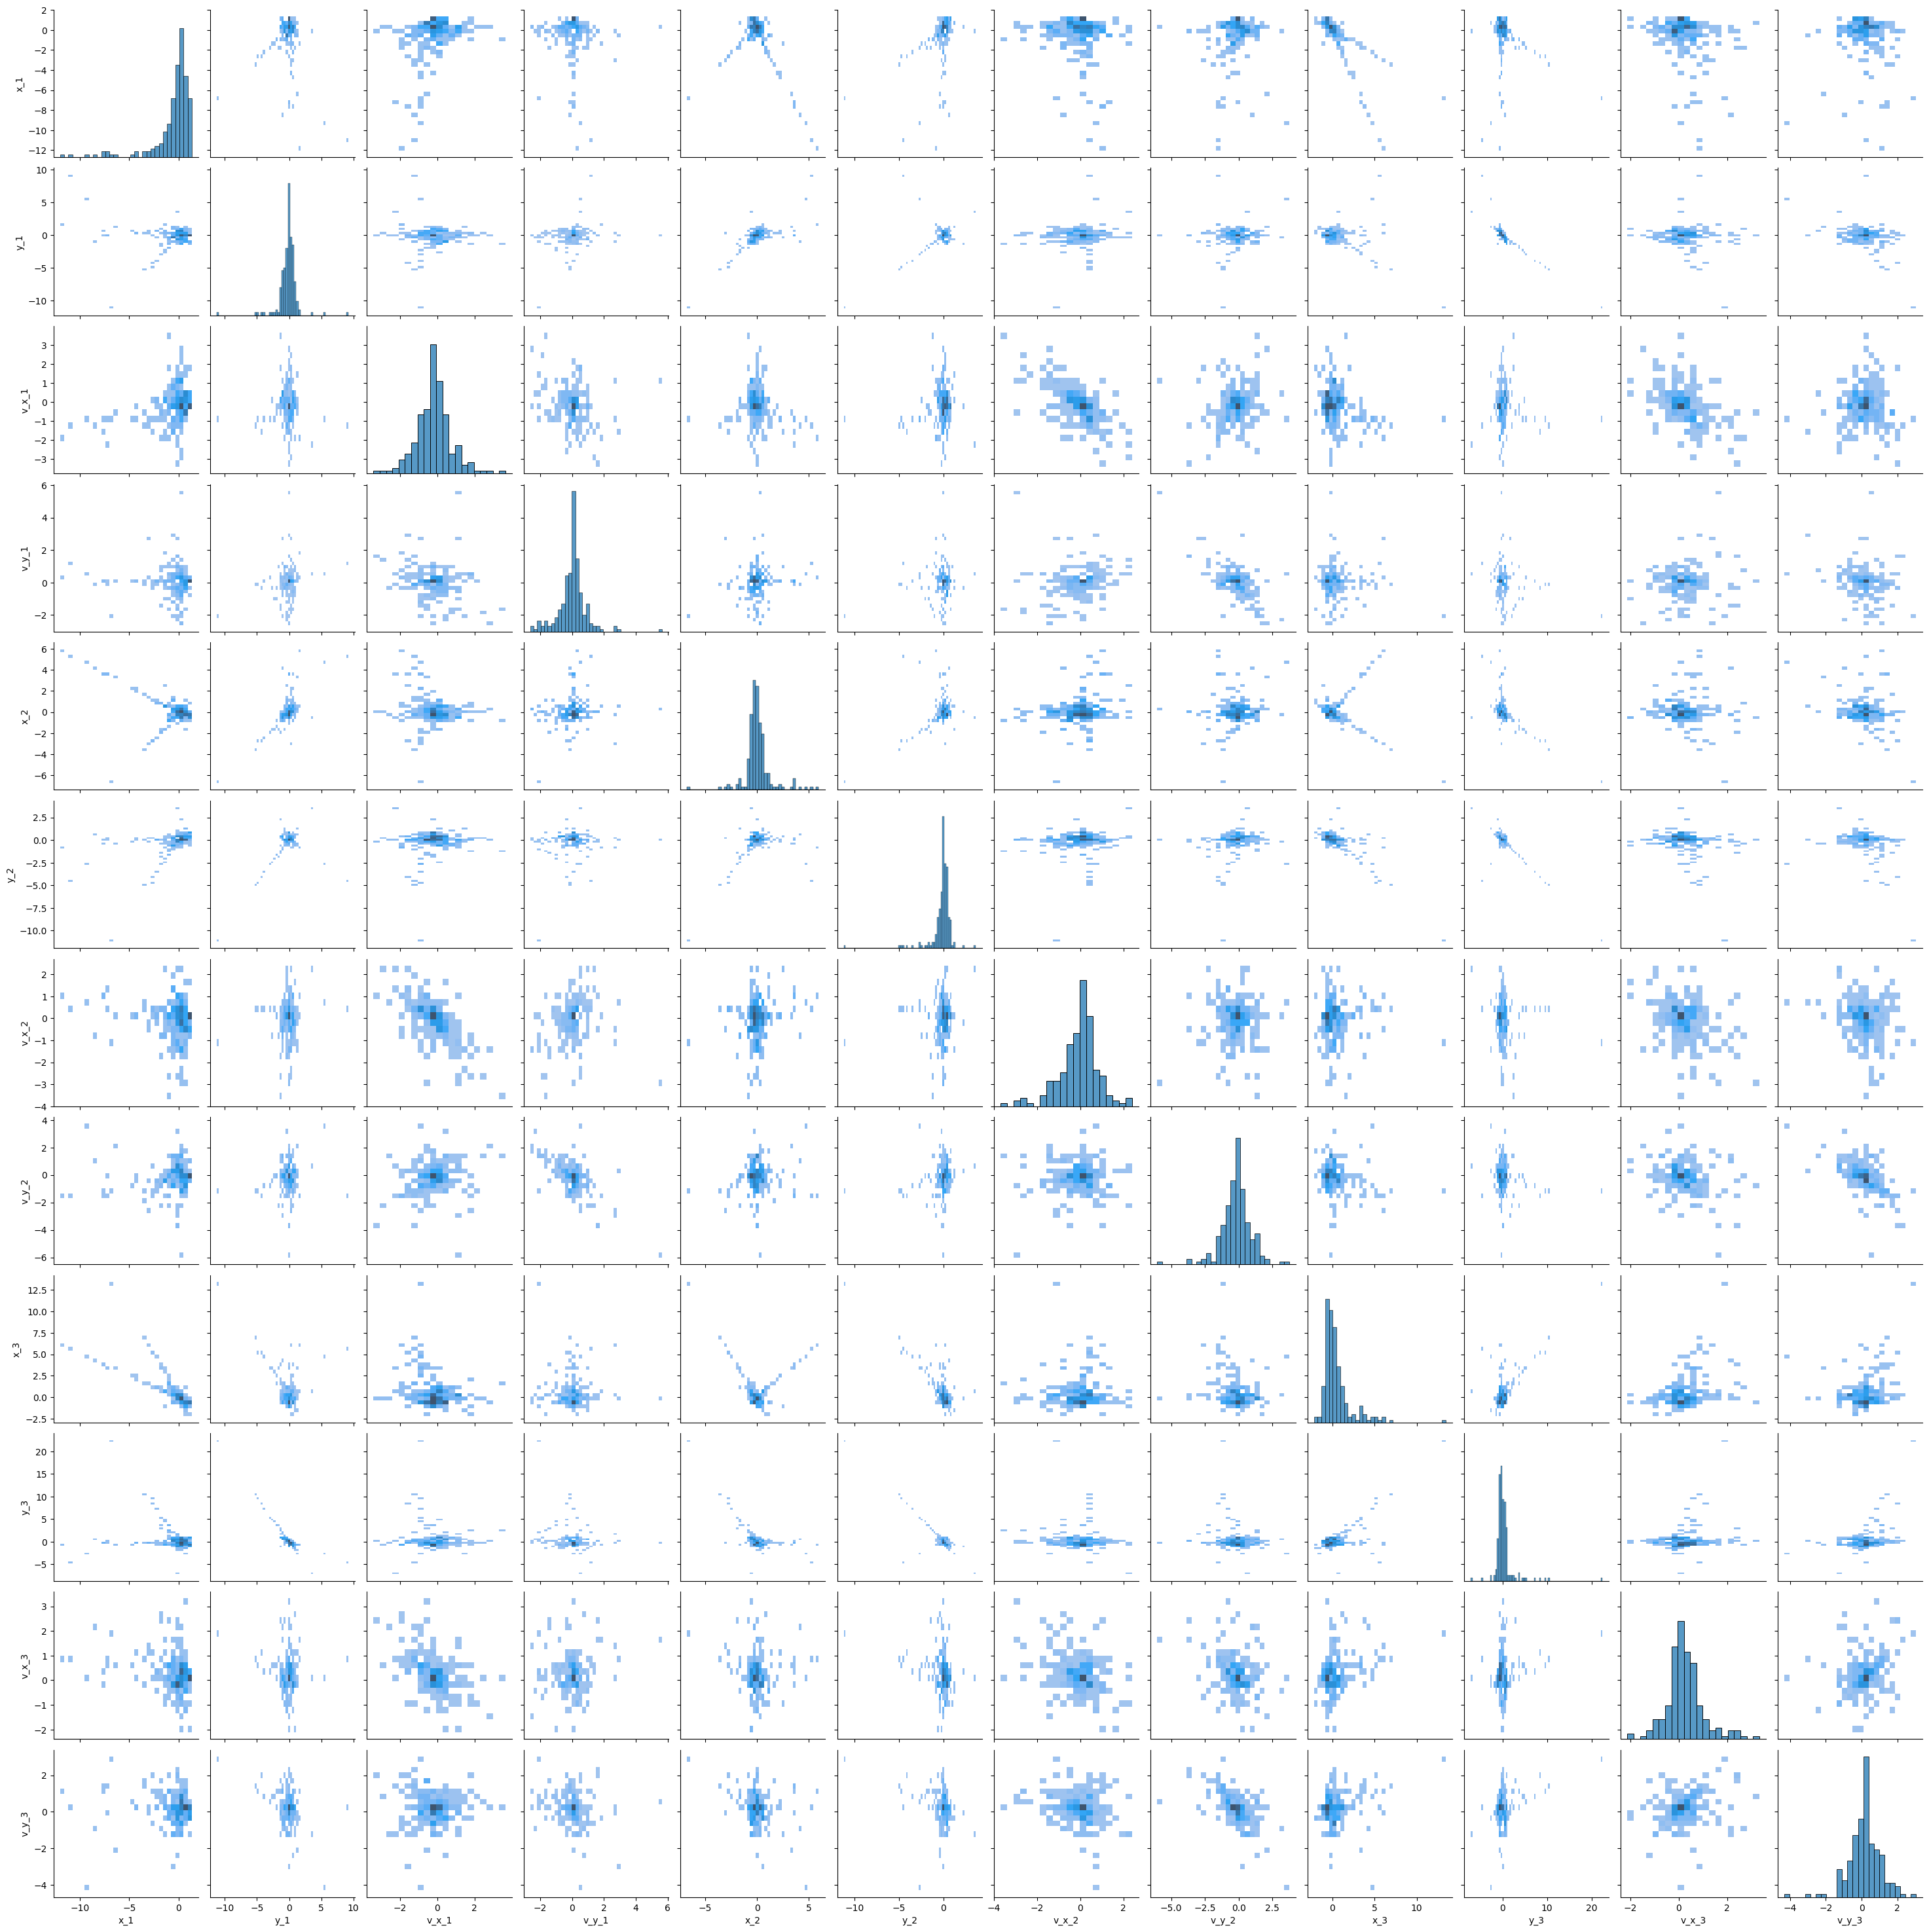

In [30]:
sns.pairplot(x_train.drop(columns=["t", "Id", "TRAJECTORY ID"]).sample(200), kind="hist")
plt.show()

#### Note

We can also analyze the correlation between input variables. Although we see some higher correlations between the positions of the bodies we argue that it does not make sense to remove them because the correlation is likely caused by gravitaional pull between the objects and is expected as the bodies attract each other.

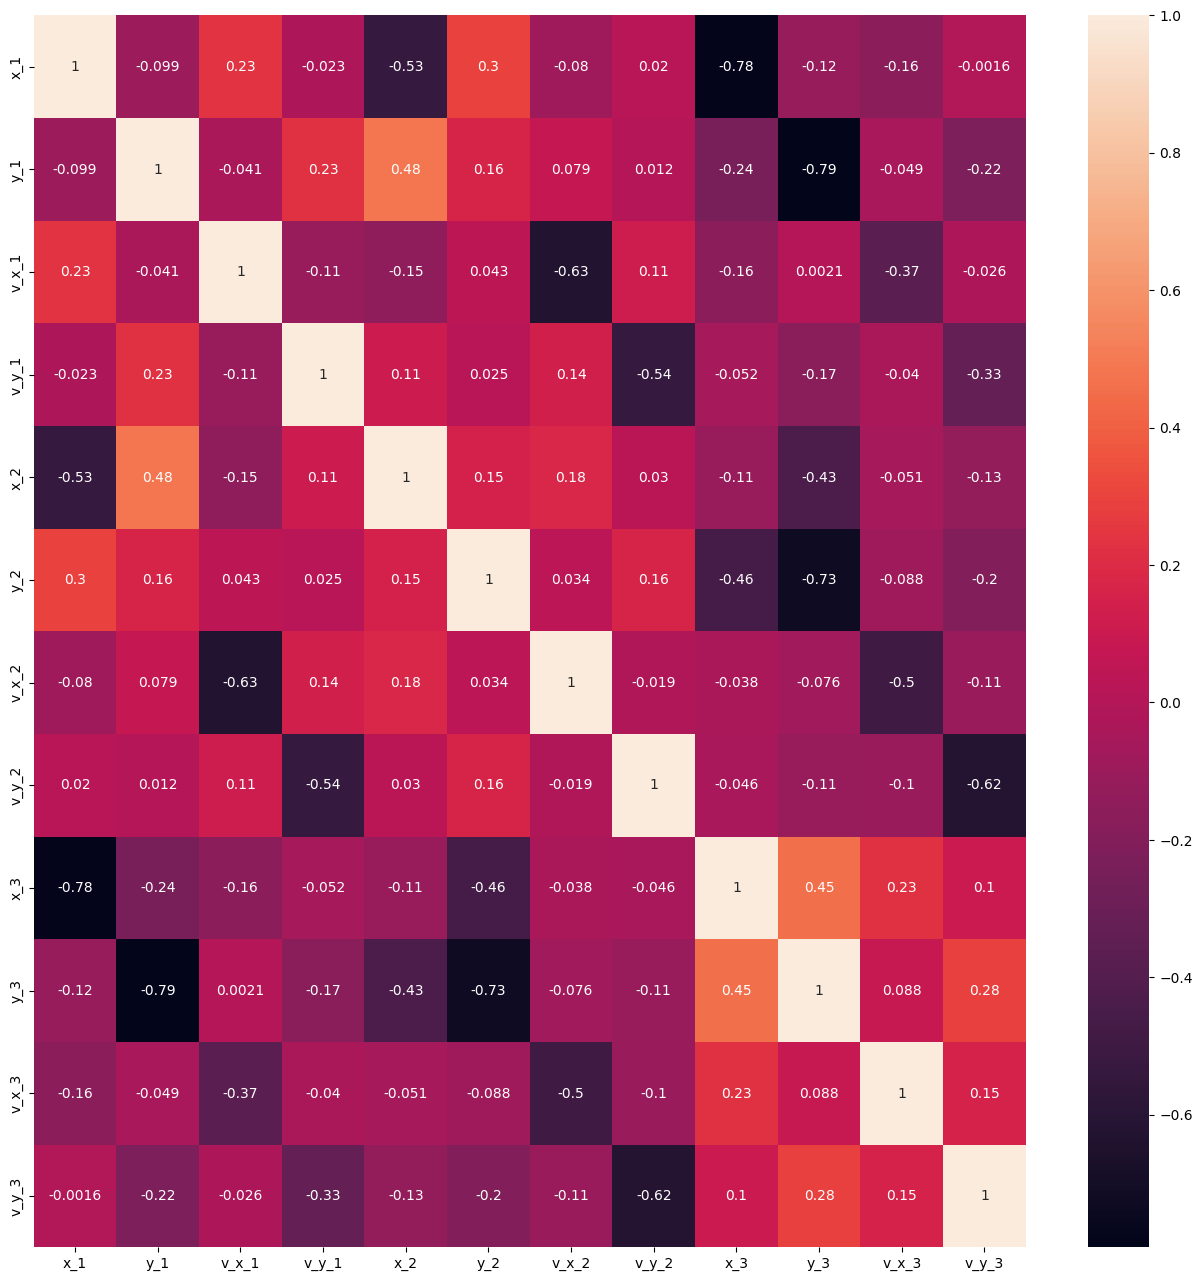

In [31]:
corr = x_train.drop(columns=["t", "Id", "TRAJECTORY ID"]).corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr,annot=True)
plt.show()

#### Sorted correlations between input features

In [32]:
# Sort the interactions by the absolute value of the correlations.
sorted_corrs = corr.abs().unstack().sort_values(ascending=False)
# create df
sorted_corrs = pd.DataFrame(sorted_corrs).reset_index()
sorted_corrs.columns = ["Feature 1", "Feature 2", "Correlation"]
# remove self correlations
sorted_corrs = sorted_corrs[sorted_corrs["Feature 1"] != sorted_corrs["Feature 2"]]
# remove duplicates
sorted_corrs = sorted_corrs.iloc[::2]
sorted_corrs.head(10)

,Feature 1,Feature 2,Correlation
12,y_1,y_3,0.792859
14,x_1,x_3,0.780996
16,y_2,y_3,0.728556
18,v_x_2,v_x_1,0.625521
20,v_y_2,v_y_3,0.622938
22,v_y_2,v_y_1,0.536511
24,x_1,x_2,0.534279
26,v_x_2,v_x_3,0.495868
28,y_1,x_2,0.484456
30,x_3,y_2,0.464365


### Analyze Feature coefficients of the polynomial model

To find out which coefficients are important for our polynomial model we can analyze the coefficients of our polynomial model. As we choose a solid regularization method the coefficients do not have a very high magnitude indicating that the model is not too sensitive for single features.

In [33]:
# Step 1: Get the polynomial feature names from the 'poly' step in the pipeline
poly_feature_names = model_polynomial.named_steps['poly'].get_feature_names_out(x_columns_train)

# Step 2: Extract the coefficients from the 'regressor' step in the pipeline
coefficients = model_polynomial.named_steps['regressor'].coef_

# Check the shape of the coefficients
print(f"Shape of the coefficients: {coefficients.shape}")

# Step 3: Since the model is multi-output, we need to handle each target variable's coefficients separately
# Assuming you have 6 target variables (based on the shape you mentioned)
target_names = [f"Target_{i+1}" for i in range(coefficients.shape[0])]

# Step 4: Create a DataFrame for each target's coefficients and combine them
coef_df_list = []

for i, target in enumerate(target_names):
    # Create a DataFrame for the current target's coefficients
    target_coef_df = pd.DataFrame({
        'Feature': poly_feature_names,
        'Coefficient': coefficients[i]
    })
    
    # Add a column to indicate which target variable these coefficients belong to
    target_coef_df['Target'] = target
    
    # Append to the list
    coef_df_list.append(target_coef_df)

# Combine all target coefficient DataFrames into one
coef_df = pd.concat(coef_df_list)

# Step 5: Sort by the absolute value of the coefficients
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

# Display the top features with the largest coefficients
display(coef_df.head(10))

Shape of the coefficients: (12, 2379)


,Feature,Coefficient,Target,Abs_Coefficient
2378,t^4,4.855671,Target_1,4.855671
1389,x_2^2 y_2^2,-3.193011,Target_1,3.193011
1391,x_2^2 y_2 y_3,3.193011,Target_1,3.193011
1408,x_2^2 y_3^2,-3.193011,Target_1,3.193011
1013,x_1 t^3,-3.111400,Target_1,3.111400
558,t^3,-3.111400,Target_1,3.111400
2048,x_3 t^3,3.007383,Target_1,3.007383
2378,t^4,-2.993243,Target_5,2.993243
1663,x_2 t^3,2.483944,Target_1,2.483944
1663,x_2 t^3,-2.190451,Target_2,2.190451


## Task 3.2 Evaluation of Variable Reduction

As we currently only have position and velocity as input variables and we do not want to remove the inital positions as we see them as a mandatory input we want to try the model without the velocities. Lets define a reduced feature set and build a polynomial model again.

In [34]:
x_columns_train_reduced = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3','t']
y_columns_train_reduced = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

alphas = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]
size_for_validation = 2000
random_state = 42
(
    best_model,
    best_rmse,
    best_degree,
    best_alpha,
    rmses,
    feature_counts,
    polynomial_validation_results,
) = validate_poly_regression(
    X_train.sample(size_for_validation, random_state=random_state),
    y_train.sample(size_for_validation, random_state=random_state),
    X_val.sample(size_for_validation, random_state=random_state),
    y_val.sample(size_for_validation, random_state=random_state),
    degrees=range(1, 6),
    alphas=alphas,
    x_columns_train=x_columns_train_reduced,
    y_columns_train=y_columns_train_reduced,
)

print(
    f"Best degree: {best_degree}, Best RMSE: {best_rmse}",
    f"Best alpha: {best_alpha}",
    f"Number of features: {best_model.named_steps['poly'].n_output_features_}",
)

Degree: 1, Alpha: 0.01, Features: 7, RMSE: 1.4247734212783183
Degree: 1, Alpha: 0.05, Features: 7, RMSE: 1.4247739647144864
Degree: 1, Alpha: 0.1, Features: 7, RMSE: 1.4247746440417768
Degree: 1, Alpha: 0.2, Features: 7, RMSE: 1.4247760028032728
Degree: 1, Alpha: 0.5, Features: 7, RMSE: 1.424780079942556
Degree: 1, Alpha: 1.0, Features: 7, RMSE: 1.4247868780207942
Degree: 1, Alpha: 2.0, Features: 7, RMSE: 1.424800484825871
Degree: 1, Alpha: 5.0, Features: 7, RMSE: 1.4248413899463437
Degree: 1, Alpha: 10.0, Features: 7, RMSE: 1.4249098442977828
Degree: 1, Alpha: 20.0, Features: 7, RMSE: 1.4250477761635816
Degree: 1, Alpha: 50.0, Features: 7, RMSE: 1.4254693011014292
Degree: 2, Alpha: 0.01, Features: 35, RMSE: 1.3840229973741873
Degree: 2, Alpha: 0.05, Features: 35, RMSE: 1.3840225219911906
Degree: 2, Alpha: 0.1, Features: 35, RMSE: 1.3840219306928254
Degree: 2, Alpha: 0.2, Features: 35, RMSE: 1.3840207578413628
Degree: 2, Alpha: 0.5, Features: 35, RMSE: 1.3840173168219894
Degree: 2, Alp

#### Note

We can see down below that the scores of the model increased indicating a better performance with the reduced feature set. (The sklearn score is the R^2 score where the perfect score is 1.0)

In [71]:
# Create polynomial features
model_polynomial_reduced = Pipeline(
    steps=[
        ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
        ("scaler", StandardScaler()),
        ("regressor", Ridge(alpha=best_alpha)),
    ]
)


y_pred_train_poly_reduced, y_pred_val_poly_reduced, y_pred_test_poly_reduced, model_polynomial_reduced, polynomial_reduced_results = train_model(
    model_polynomial,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    x_columns_train_reduced,
    y_columns_train_reduced,
)

Train score: 0.2275
Validation score: 0.2551
Test score: 0.1824


In [36]:
_ = create_submission(model_polynomial_reduced, "reduced_polynomial_submission.csv", x_test_real, x_columns_train_reduced, y_columns_train_reduced, x_columns_submissions)

## Task 3.3 Adding Variables

In an attempt to improve the model lets create some features. Because we are dealing with a process that follows the gravitational law we decided to calculate the pairwise distance between the bodies as well as the gravitational forces. In order to account for numerical stability we choose a correspondig mass.

In [37]:
def create_features(X_data):
    # Constants
    G = 6.67430e-11  # gravitational constant in m^3 kg^-1 s^-2
    m1, m2, m3 = 1.0*10**5, 1.0*10**5, 1.0*10**5  # Masses of the three bodies

    # Calculate pairwise distances between bodies
    X_data['r_12'] = np.sqrt((X_data['x_1'] - X_data['x_2'])**2 + (X_data['y_1'] - X_data['y_2'])**2)
    X_data['r_13'] = np.sqrt((X_data['x_1'] - X_data['x_3'])**2 + (X_data['y_1'] - X_data['y_3'])**2)
    X_data['r_23'] = np.sqrt((X_data['x_2'] - X_data['x_3'])**2 + (X_data['y_2'] - X_data['y_3'])**2)

    # Calculate gravitational forces between each pair of bodies
    X_data['F_12'] = G * m1 * m2 / X_data['r_12']**2
    X_data['F_13'] = G * m1 * m3 / X_data['r_13']**2
    X_data['F_23'] = G * m2 * m3 / X_data['r_23']**2

    ## Calculate center of mass
    X_data['x_com'] = (m1 * X_data['x_1'] + m2 * X_data['x_2'] + m3 * X_data['x_3']) / (m1 + m2 + m3)

    ## Calculate polar coordinates for each body with respect to the center of mass
    X_data['theta_1'] = np.arctan2(X_data['y_1'], X_data['x_1'] - X_data['x_com'])
    X_data['theta_2'] = np.arctan2(X_data['y_2'], X_data['x_2'] - X_data['x_com'])
    X_data['theta_3'] = np.arctan2(X_data['y_3'], X_data['x_3'] - X_data['x_com'])
    ## Clean up any infinities or NaN values created during calculation
    X_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_data.fillna(0, inplace=True)
    
    return X_data


X_data_features = create_features(X_data)
x_test_real_features = create_features(x_test_real)


In [38]:
# use create_train_val_test_splits to create data from X_data, y_data
x_columns_train_features = x_columns_train_reduced +["theta_1", "theta_2", "theta_3", "r_12", "r_13", "r_23"]#["r_12", "r_13", "r_23", "x_com"]#['F_12', 'F_13', 'F_23']
X_train, X_val, X_test, y_train, y_val, y_test = create_train_val_test_splits(X_data, y_data, x_columns_train_features, y_columns_train_reduced, random_state=42)


#### Find best model

In [39]:
# alphas = [0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 200.0, 1000, 5000, 10000, 200000, 300000]
alphas = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0]
size_for_validation = 200
random_state = 42
(
    best_model,
    best_rmse,
    best_degree,
    best_alpha,
    rmses,
    feature_counts,
    polynomial_feature_validation_results,
) = validate_poly_regression(
    X_train.sample(size_for_validation, random_state=random_state),
    y_train.sample(size_for_validation, random_state=random_state),
    X_val.sample(size_for_validation, random_state=random_state),
    y_val.sample(size_for_validation, random_state=random_state),
    degrees=range(1, 5),
    alphas=alphas,
    x_columns_train=x_columns_train_features,
    y_columns_train=y_columns_train_reduced,
)

print(
    f"Best degree: {best_degree}, Best RMSE: {best_rmse}",
    f"Best alpha: {best_alpha}",
    f"Number of features: {best_model.named_steps['poly'].n_output_features_}",
)

Degree: 1, Alpha: 0.01, Features: 13, RMSE: 1.3771589400026338
Degree: 1, Alpha: 0.05, Features: 13, RMSE: 1.380375667051978
Degree: 1, Alpha: 0.1, Features: 13, RMSE: 1.3843233989063184
Degree: 1, Alpha: 0.2, Features: 13, RMSE: 1.3894573666992043
Degree: 1, Alpha: 0.5, Features: 13, RMSE: 1.3961459033105315
Degree: 1, Alpha: 1.0, Features: 13, RMSE: 1.3999933169161973
Degree: 1, Alpha: 2.0, Features: 13, RMSE: 1.4030889187890718
Degree: 1, Alpha: 5.0, Features: 13, RMSE: 1.4072038760972523
Degree: 1, Alpha: 10.0, Features: 13, RMSE: 1.4106596320714282
Degree: 1, Alpha: 20.0, Features: 13, RMSE: 1.4147385280033278
Degree: 1, Alpha: 50.0, Features: 13, RMSE: 1.4229074913171869
Degree: 2, Alpha: 0.01, Features: 104, RMSE: 1.2755790905282058
Degree: 2, Alpha: 0.05, Features: 104, RMSE: 1.2797147435201734
Degree: 2, Alpha: 0.1, Features: 104, RMSE: 1.286196701194107
Degree: 2, Alpha: 0.2, Features: 104, RMSE: 1.2946502841440741
Degree: 2, Alpha: 0.5, Features: 104, RMSE: 1.307472367440703

#### Note

We can see that the features selected did not improve the model

In [72]:
# Create polynomial features
model_polynomial_features = Pipeline(steps=[
                ('poly', PolynomialFeatures(degree=best_degree, include_bias=False)),
                ('scaler', StandardScaler()),
                ('regressor', Ridge(alpha=best_alpha))
            ])


y_pred_train_polynomial_feature, y_pred_val_polynomial_feature, y_pred_test_polynomial_feature, model_polynomial_features, polynomial_features_results = train_model(model_polynomial_features, X_train, y_train, X_val, y_val, X_test, y_test, x_columns_train_features, y_columns_train_reduced)

Train score: 0.2886
Validation score: 0.3078
Test score: 0.2209


## Task 3.4 Evaluation of Variable Augmentation

#### Evaluation

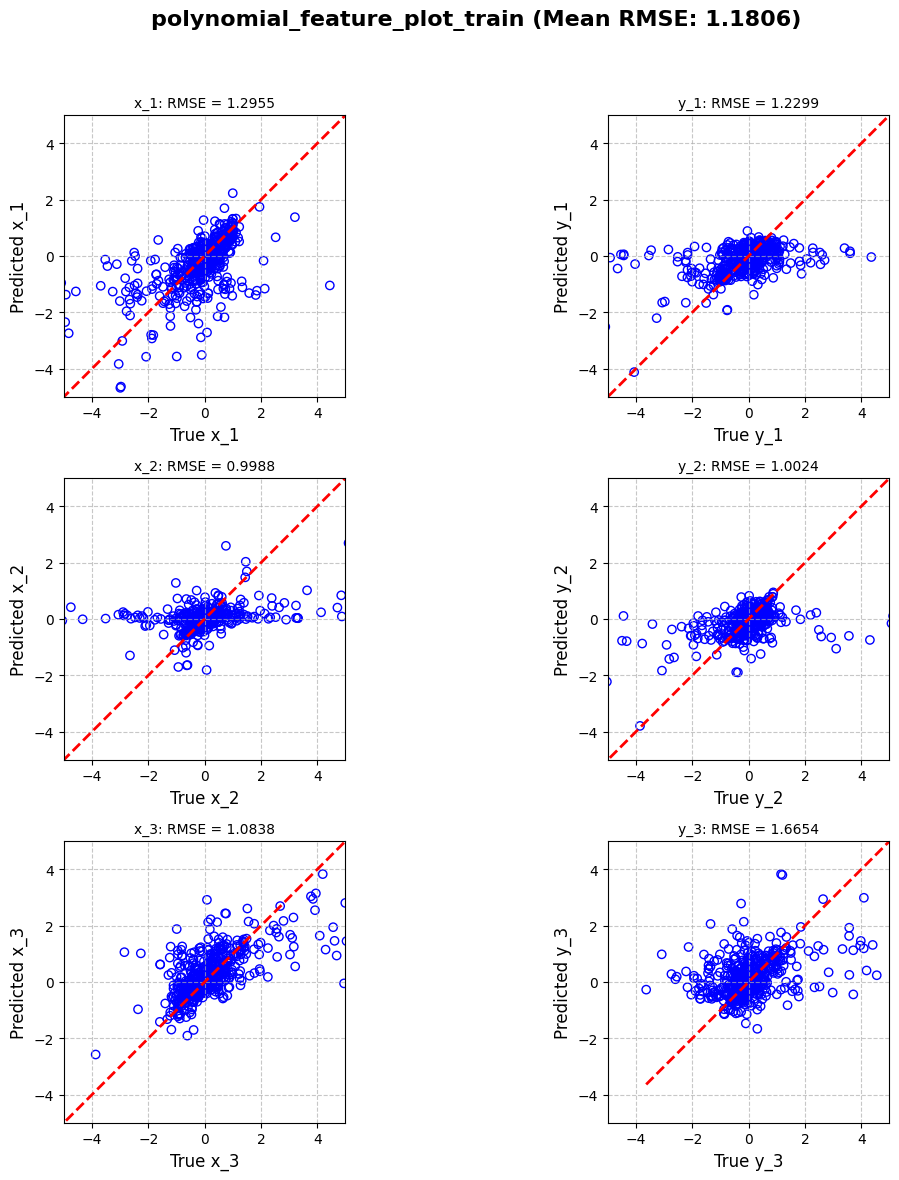

In [41]:
plot_y_yhat(y_train[y_columns_train_reduced], y_pred_train_polynomial_feature, plot_title="polynomial_feature_plot_train")

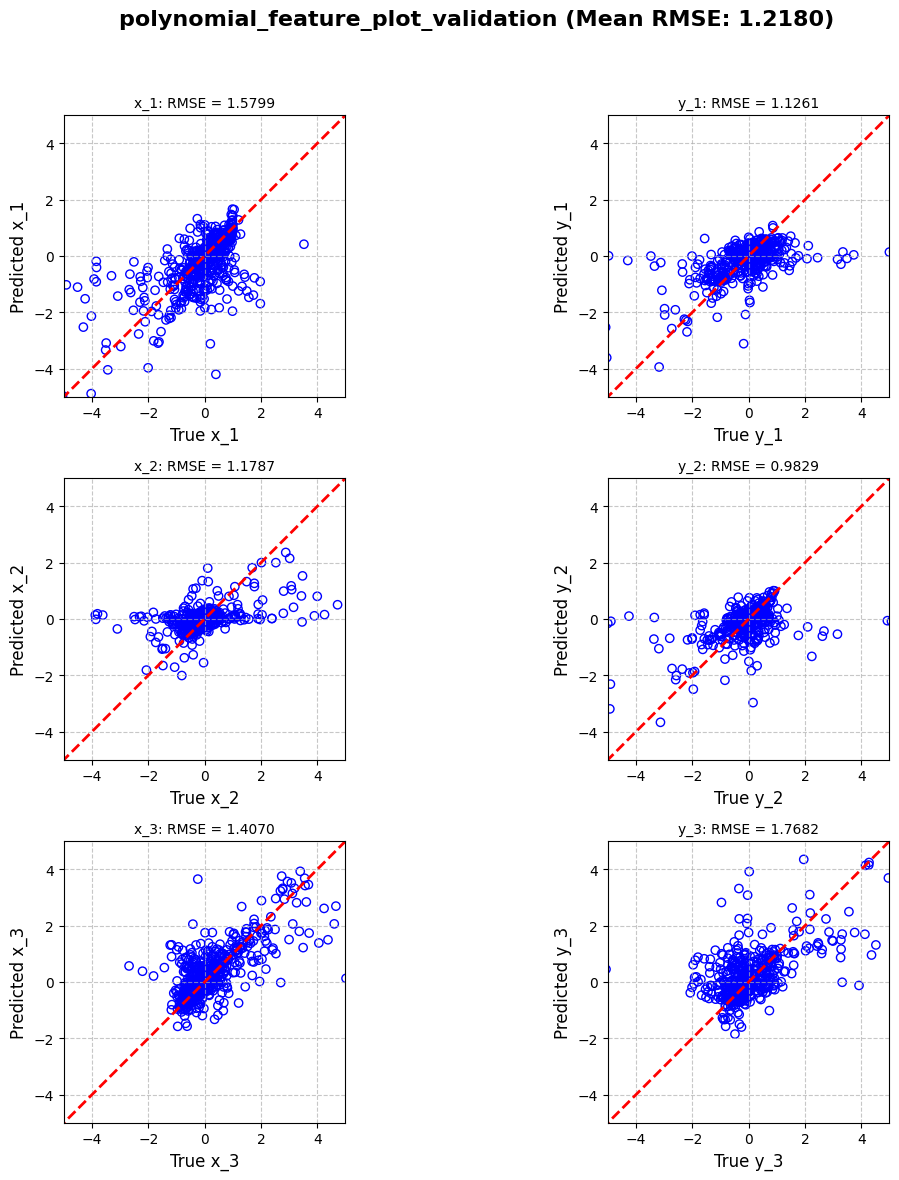

In [42]:
plot_y_yhat(y_val[y_columns_train_reduced], y_pred_val_polynomial_feature, plot_title="polynomial_feature_plot_validation")

#### Create submission

In [43]:
_ = create_submission(model_polynomial_features, "polynomial_feature_submission.csv", x_test_real_features, x_columns_train_features, y_columns_train_reduced, x_columns_submissions)

# Task 4: Nonparamentric Model — the k-Nearest Neighbors Regressor

## Task 4.1 Development

In [44]:
from sklearn.neighbors import KNeighborsRegressor

def validate_knn_regression(
    X_train,
    y_train,
    X_val,
    y_val,
    k=range(1, 4),
    algorithms=['auto'],
    leaf_sizes=[30],
    metrics=['minkowski'],
    p_values=[2],
    x_columns_train=None,
    y_columns_train=None
):
    best_rmse = float('inf')
    best_model = None
    best_params = None
    rmses_val = []
    results = pd.DataFrame(columns=["k", "algorithm", "leaf_size", "metric", "p", "rmse_val"])

    # Use all columns if none are specified
    if x_columns_train is None:
        x_columns_train = X_train.columns
    if y_columns_train is None:
        y_columns_train = y_train.columns

    # Prepare the data
    X_train = X_train[x_columns_train]
    X_val = X_val[x_columns_train]
    y_train = y_train[y_columns_train]
    y_val = y_val[y_columns_train]

    # Iterate over all combinations of parameters
    for k_value in k:
        for algorithm in algorithms:
            for leaf_size in leaf_sizes:
                for metric in metrics:
                    if metric == 'minkowski':
                        for p in p_values:
                            # Create the regressor with current parameters
                            regressor = KNeighborsRegressor(
                                n_neighbors=k_value,
                                algorithm=algorithm,
                                leaf_size=leaf_size,
                                metric=metric,
                                p=p
                            )
                            # Train the model
                            regressor.fit(X_train, y_train)

                            # Predict on validation data
                            y_pred = regressor.predict(X_val)

                            # Calculate RMSE
                            rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
                            rmses_val.append(rmse_val)

                            # Save results
                            results = pd.concat([
                                results,
                                pd.DataFrame([[
                                    k_value, algorithm, leaf_size, metric, p, rmse_val
                                ]], columns=["k", "algorithm", "leaf_size", "metric", "p", "rmse_val"])
                            ], ignore_index=True)

                            # Print current parameters and RMSE
                            print(f"k: {k_value}, algorithm: {algorithm}, leaf_size: {leaf_size}, metric: {metric}, p: {p}, RMSE: {rmse_val}")

                            # Update the best model if this is the best RMSE so far
                            if rmse_val < best_rmse:
                                best_rmse = rmse_val
                                best_model = regressor
                                best_params = {
                                    'k': k_value,
                                    'algorithm': algorithm,
                                    'leaf_size': leaf_size,
                                    'metric': metric,
                                    'p': p
                                }
                    else:
                        # p is not relevant
                        p = None
                        # Create the regressor with current parameters
                        regressor = KNeighborsRegressor(
                            n_neighbors=k_value,
                            algorithm=algorithm,
                            leaf_size=leaf_size,
                            metric=metric
                        )
                        # Train the model
                        regressor.fit(X_train, y_train)

                        # Predict on validation data
                        y_pred = regressor.predict(X_val)

                        # Calculate RMSE
                        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred))
                        rmses_val.append(rmse_val)

                        # Save results
                        results = pd.concat([
                            results,
                            pd.DataFrame([[
                                k_value, algorithm, leaf_size, metric, p, rmse_val
                            ]], columns=["k", "algorithm", "leaf_size", "metric", "p", "rmse_val"])
                        ], ignore_index=True)

                        # Print current parameters and RMSE
                        print(f"k: {k_value}, algorithm: {algorithm}, leaf_size: {leaf_size}, metric: {metric}, p: {p}, RMSE: {rmse_val}")

                        # Update the best model if this is the best RMSE so far
                        if rmse_val < best_rmse:
                            best_rmse = rmse_val
                            best_model = regressor
                            best_params = {
                                'n_neighbors': k_value,
                                'algorithm': algorithm,
                                'leaf_size': leaf_size,
                                'metric': metric,
                                'p': p
                            }

    # Return the best model, the best RMSE, the best parameters, and the results
    return best_model, best_rmse, best_params, rmses_val, results




In [45]:
X_train, X_val, X_test, y_train, y_val, y_test = create_train_val_test_splits(X_data, y_data, x_columns_train_features, y_columns_train_reduced, random_state=42)

In [46]:
size_for_validation = 20000
algorithms = ['auto', 'ball_tree', 'kd_tree']
leaf_sizes = [30]
metrics = ['manhattan', 'minkowski']
p_values = [1, 2]
n_neighbors = range(1, 15)
# get the best k
best_model, best_rmse, best_params, rmses_val, results_knn = (
    validate_knn_regression(
        X_train.sample(size_for_validation, random_state=random_state),
        y_train.sample(size_for_validation, random_state=random_state),
        X_val.sample(size_for_validation, random_state=random_state),
        y_val.sample(size_for_validation, random_state=random_state),
        k=n_neighbors,
        algorithms=algorithms,
        leaf_sizes=leaf_sizes,
        metrics=metrics,
        p_values=p_values,
        x_columns_train=x_columns_train_features,
        y_columns_train=y_columns_train_reduced,
    )
)

k: 1, algorithm: auto, leaf_size: 30, metric: manhattan, p: None, RMSE: 1.4166921952293645
k: 1, algorithm: auto, leaf_size: 30, metric: minkowski, p: 1, RMSE: 1.4166921952293645
k: 1, algorithm: auto, leaf_size: 30, metric: minkowski, p: 2, RMSE: 1.4633544845250552
k: 1, algorithm: ball_tree, leaf_size: 30, metric: manhattan, p: None, RMSE: 1.4166894251328066
k: 1, algorithm: ball_tree, leaf_size: 30, metric: minkowski, p: 1, RMSE: 1.4166894251328066
k: 1, algorithm: ball_tree, leaf_size: 30, metric: minkowski, p: 2, RMSE: 1.4633534668165091
k: 1, algorithm: kd_tree, leaf_size: 30, metric: manhattan, p: None, RMSE: 1.4166921952293645
k: 1, algorithm: kd_tree, leaf_size: 30, metric: minkowski, p: 1, RMSE: 1.4166921952293645
k: 1, algorithm: kd_tree, leaf_size: 30, metric: minkowski, p: 2, RMSE: 1.4633544845250552
k: 2, algorithm: auto, leaf_size: 30, metric: manhattan, p: None, RMSE: 1.1982151171955793
k: 2, algorithm: auto, leaf_size: 30, metric: minkowski, p: 1, RMSE: 1.1982151171955

#### Build best KNN Model

Lets see the results of the hyperparameter search to validate the best parameters.

In [47]:
results_knn.sort_values(by="rmse_val").head(10)

,k,algorithm,leaf_size,metric,p,rmse_val
102,12,ball_tree,30,manhattan,None,1.090294
103,12,ball_tree,30,minkowski,1,1.090294
99,12,auto,30,manhattan,None,1.090296
100,12,auto,30,minkowski,1,1.090296
105,12,kd_tree,30,manhattan,None,1.090296
106,12,kd_tree,30,minkowski,1,1.090296
112,13,ball_tree,30,minkowski,1,1.090586
111,13,ball_tree,30,manhattan,None,1.090586
108,13,auto,30,manhattan,None,1.090592
115,13,kd_tree,30,minkowski,1,1.090592


In [48]:
best_params

{'n_neighbors': 12,
 'algorithm': 'ball_tree',
 'leaf_size': 30,
 'metric': 'manhattan',
 'p': None}

In [73]:
knn_model = KNeighborsRegressor(
    n_neighbors=best_params['n_neighbors'],
    algorithm=best_params['algorithm'],
    leaf_size=best_params['leaf_size'],
    metric=best_params['metric'],
    p=best_params['p']
)

y_pred_train_knn, y_pred_val_knn, y_pred_test_knn, knn_model, knn_results = train_model(
    knn_model,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    x_columns_train_features,
    y_columns_train_reduced,
)

Train score: 0.8754
Validation score: 0.5758
Test score: 0.5178


#### KNN Evaluation

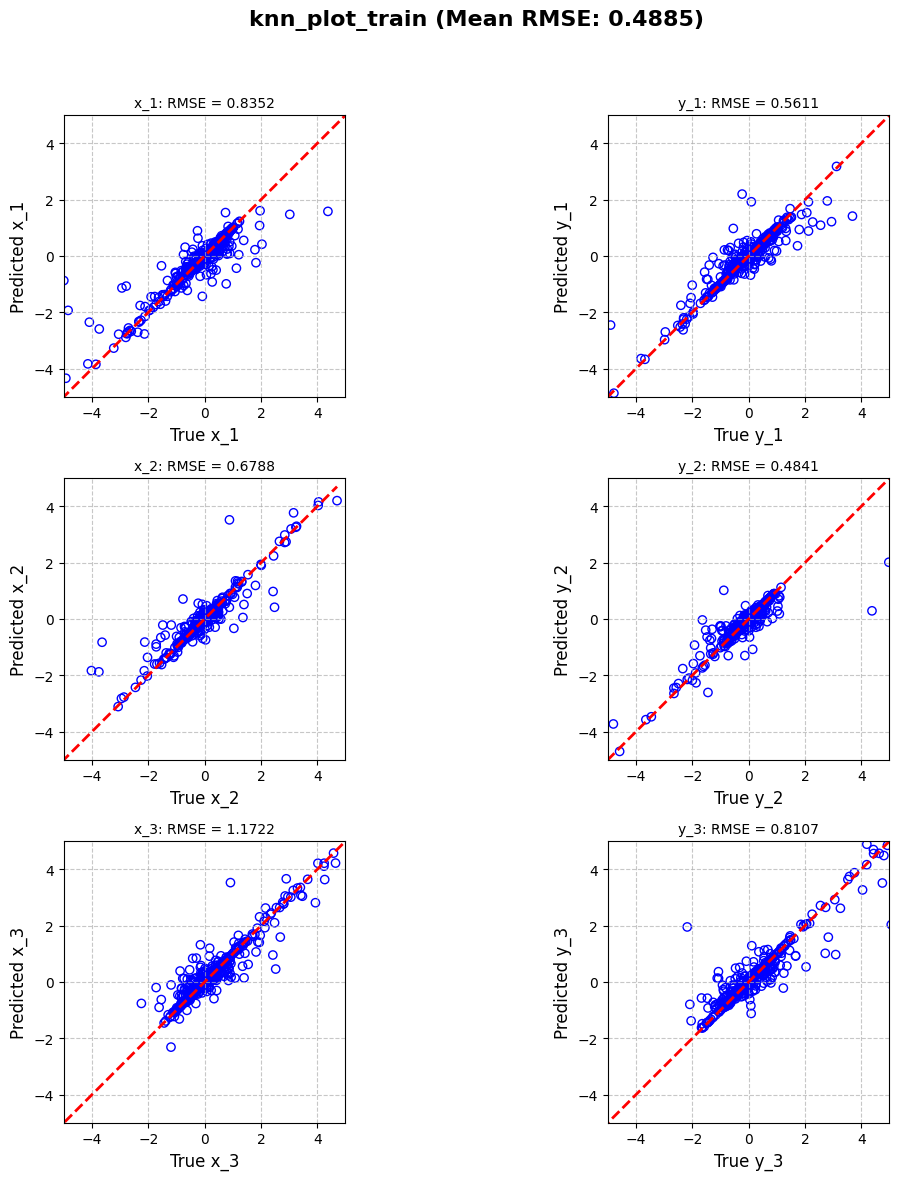

In [50]:
plot_y_yhat(y_train[y_columns_train_reduced], y_pred_train_knn, plot_title="knn_plot_train")

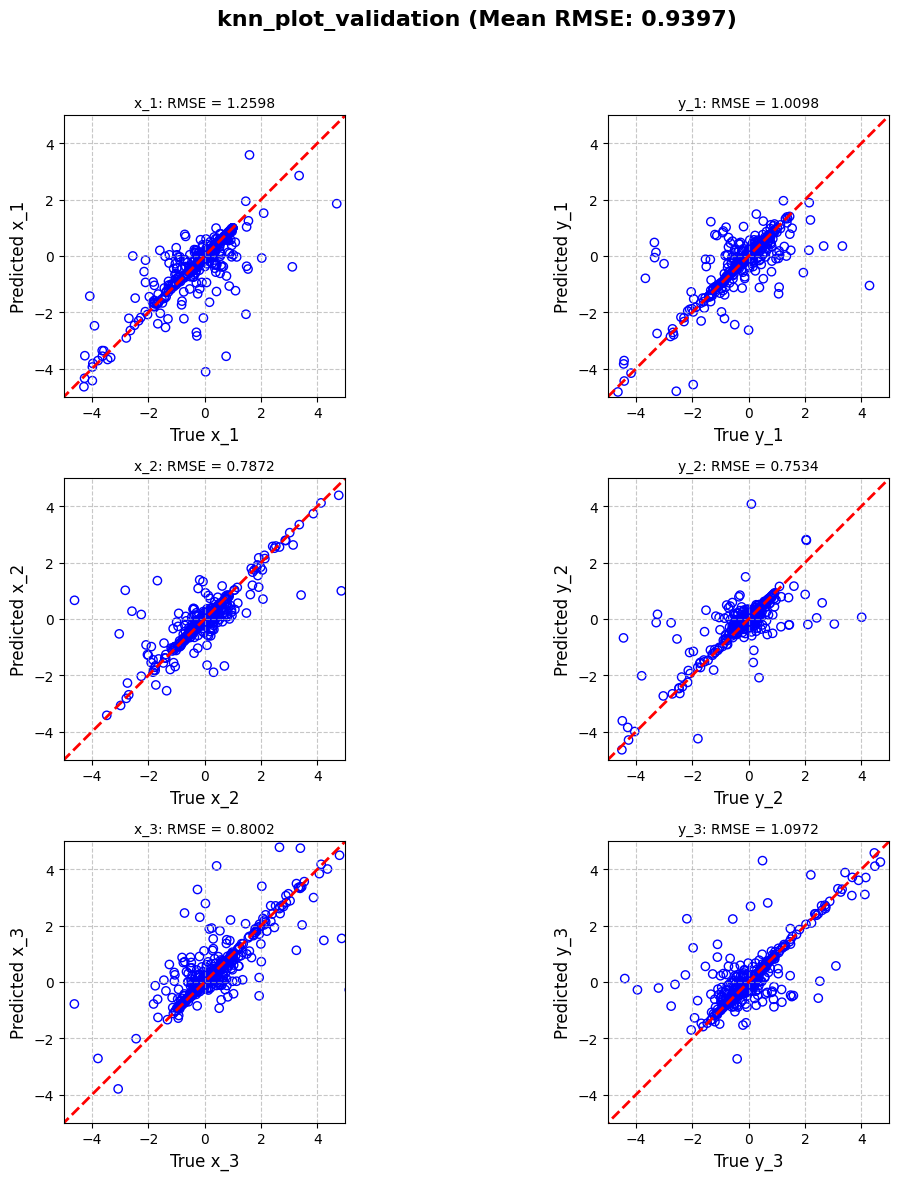

In [51]:
plot_y_yhat(y_val[y_columns_train_reduced], y_pred_val_knn, plot_title="knn_plot_validation")

#### KNN Submission

In [52]:
_ = create_submission(knn_model, "knn_submission.csv", x_test_real_features, x_columns_train_features, y_columns_train_reduced, x_columns_submissions)

# Task 5 Build your own model

#### Task 5.0 Try a Random Forrest

In [74]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, verbose=1)

y_pred_train_rf, y_pred_val_rf, y_pred_test_rf, rf_model, rf_results = train_model(
    rf_model,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    x_columns_train_features,
    y_columns_train_reduced,
)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  2.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s


Train score: 1.0000
Validation score: 0.4616
Test score: 0.4858


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s


In [54]:
_ = create_submission(rf_model, "rf_submission.csv", x_test_real_features, x_columns_train_features, y_columns_train_reduced, x_columns_submissions)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    7.3s


### Task 5.1 Build iterative model

Start with little training data only looking a small time period in the future and increase sequentially the time period

In [55]:
x_columns_train_ml = x_columns_train + ["theta_1", "theta_2", "theta_3", "r_12", "r_13", "r_23"]

X_data_features = create_features(X_data)
X_train, X_val, X_test, y_train, y_val, y_test = create_train_val_test_splits(X_data_features, y_data, x_columns_train_ml, y_columns_train, random_state=42)

# Define the features and target columns
feature_columns = x_columns_train_ml
target_columns = y_columns_train

#### Iterative MLP

In [ ]:
# Time step ranges (e.g., [0, 1], [1, 2], ..., [9, 10])
time_step_ranges = [(0, 0.04), (0, 0.08), (0,0.12), (0,0.16), (0, 0.2), (0, 0.3), (0, 0.4), (0, 0.5), (0, 0.6), (0, 0.8), (0, 1), (0, 1.5), (0, 2), (0, 2.5), (0, 3), (0, 3.5), (0, 4), (0,4.5), (0, 5), (0, 5.5) ,(0, 6), (0, 6.5), (0, 7), (0, 7.5), (0, 8), (0, 9), (0, 10)]

sequential_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(128, 64, 32),
                         activation='relu',
                         solver='adam',
                         max_iter=12,
                         random_state=42,
                         alpha = 0.001,
                         early_stopping=True,
                         verbose=False,
                         tol=0.01,
                         n_iter_no_change=7))
])

for t_min, t_max in time_step_ranges:
    # Filter data within the time step range
    idx_train = (X_train["t"] >= t_min) & (X_train["t"] < t_max)
    X_train_filtered = X_train[idx_train]
    y_train_filtered = y_train[idx_train]
    
    idx_val = (X_val["t"] >= t_min) & (X_val["t"] < t_max)
    X_val_filtered = X_val[idx_val]
    y_val_filtered = y_val[idx_val]
    
    # Train the sequential_mlp on the filtered data
    sequential_mlp.fit(X_train_filtered[feature_columns], y_train_filtered[target_columns])
    
    # Evaluate on the validation set
    y_val_pred = sequential_mlp.predict(X_val_filtered[feature_columns])
    val_mse = mean_squared_error(y_val_filtered[target_columns], y_val_pred)
    print(f'Validation MSE for time step range [{t_min}, {t_max}]: {val_mse}')

    # Evaluate on whole test set
    y_test_pred = sequential_mlp.predict(X_test[feature_columns])
    test_mse = mean_squared_error(y_test[target_columns], y_test_pred)
    print(f'Test MSE [{t_min}, {t_max}]: {test_mse}')

# Final evaluation on the test set
y_test_pred = sequential_mlp.predict(X_test[feature_columns])
test_mse = mean_squared_error(y_test[target_columns], y_test_pred)
print(f'Final Test MSE: {test_mse}')

Validation MSE for time step range [0, 0.04]: 0.0070336376924943775
Test MSE [0, 0.04]: 3485.0408919162132
Validation MSE for time step range [0, 0.08]: 0.006401037387963326
Test MSE [0, 0.08]: 87.61909488185891
Validation MSE for time step range [0, 0.12]: 0.0123250313147705
Test MSE [0, 0.12]: 42.49521809922758
Validation MSE for time step range [0, 0.16]: 0.008093721533277714
Test MSE [0, 0.16]: 267.00060735350286
Validation MSE for time step range [0, 0.2]: 0.009159150958945926
Test MSE [0, 0.2]: 31.92387853107164
Validation MSE for time step range [0, 0.3]: 0.025363169576367018
Test MSE [0, 0.3]: 228.2394362502031
Validation MSE for time step range [0, 0.4]: 0.027946255655697194
Test MSE [0, 0.4]: 89.55219976855479
Validation MSE for time step range [0, 0.5]: 0.025522885875351068
Test MSE [0, 0.5]: 53.084173466358436
Validation MSE for time step range [0, 0.6]: 0.03835406423718175
Test MSE [0, 0.6]: 23.39139885645756
Validation MSE for time step range [0, 0.8]: 0.03648404929133025

In [ ]:
print(sequential_mlp.score(X_test[feature_columns], y_test[target_columns]))
joblib.dump(sequential_mlp, 'sequential_mlp.pkl')

['sequential_mlp.pkl']

In [ ]:
_ = create_submission(sequential_mlp, "sequential_mlp.csv", x_test_real_features, x_columns_train_ml, y_columns_train, x_columns_submissions)

,Id,x_1,y_1,x_2,y_2,x_3,y_3
0,0,0.413982,0.048305,-0.047772,0.383751,-0.370521,-0.426802
1,1,0.706014,0.013229,-0.136449,0.558314,-0.573039,-0.569276
2,2,0.999160,-0.021391,-0.222745,0.736694,-0.779067,-0.716135
3,3,1.064920,-0.019548,-0.234290,0.768157,-0.833330,-0.749776
4,4,1.023602,0.017935,-0.212485,0.720678,-0.814406,-0.738378
...,...,...,...,...,...,...,...
1041616,1041616,-0.016021,0.580134,0.286005,-0.049232,-0.273052,-0.510115
1041617,1041617,-0.019268,0.585258,0.291140,-0.048822,-0.274945,-0.515545
1041618,1041618,-0.022515,0.590384,0.296277,-0.048412,-0.276838,-0.520976
1041619,1041619,-0.025762,0.595508,0.301413,-0.048002,-0.278731,-0.526406


# Model Comparison

In [83]:
model_comparison = pd.DataFrame({
    'Model': ['Baseline', 'Polynomial', 'Polynomial Reduced', 'Polynomial Features', 'KNN', 'Random Forest', 'Sequential MLP'],
    'Train RMSE': [baseline_results['train_rmse'], polynomial_results['train_rmse'], polynomial_reduced_results['train_rmse'], polynomial_features_results['train_rmse'], knn_results['train_rmse'], rf_results['train_rmse'], 0],
    'Val RMSE': [baseline_results['val_rmse'], polynomial_results['val_rmse'], polynomial_reduced_results['val_rmse'], polynomial_features_results['val_rmse'], knn_results['val_rmse'], rf_results['val_rmse'], 0],
    'Test RMSE': [baseline_results['test_rmse'], polynomial_results['test_rmse'], polynomial_reduced_results['test_rmse'], polynomial_features_results['test_rmse'], knn_results['test_rmse'], rf_results['test_rmse'], 0],
    'RMSE_over_time': [baseline_results['rmse_over_time'], polynomial_results['rmse_over_time'], polynomial_reduced_results['rmse_over_time'], polynomial_features_results['rmse_over_time'], knn_results['rmse_over_time'], rf_results['rmse_over_time'], [0]],
    'Train Score': [baseline_results['train_score'], polynomial_results['train_score'], polynomial_reduced_results['train_score'], polynomial_features_results['train_score'], knn_results['train_score'], rf_results['train_score'], 0],
    'Val Score': [baseline_results['val_score'], polynomial_results['val_score'], polynomial_reduced_results['val_score'], polynomial_features_results['val_score'], knn_results['val_score'], rf_results['val_score'], 0],
    'Test Score': [baseline_results['test_score'], polynomial_results['test_score'], polynomial_reduced_results['test_score'], polynomial_features_results['test_score'], knn_results['test_score'], rf_results['test_score'], 0]

})
model_comparison.head()

,Model,Train RMSE,Val RMSE,Test RMSE,RMSE_over_time,Train Score,Val Score,Test Score
0,Baseline,1.172762,1.211139,1.331502,"([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, ...",0.054788,0.058734,0.050004
1,Polynomial,1.103771,1.127201,1.277734,"([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, ...",0.129926,0.145986,0.103767
2,Polynomial Reduced,1.251905,1.289406,1.512176,"([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, ...",0.227541,0.255060,0.182404
3,Polynomial Features,1.195730,1.239150,1.475230,"([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, ...",0.288615,0.307847,0.220856
4,KNN,0.492737,0.953499,1.171538,"([0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, ...",0.875382,0.575770,0.517771


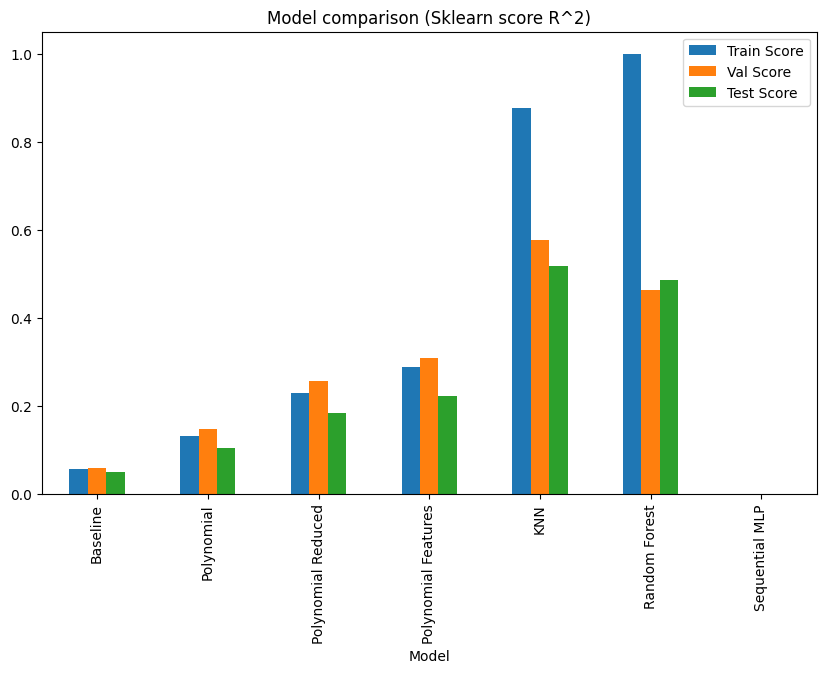

In [114]:
model_comparison.plot(kind='bar', x='Model', y=['Train Score', 'Val Score', 'Test Score'], title="Model comparison (Sklearn score R^2)",figsize=(10, 6))
plt.savefig('images/model_comparison_score.png')

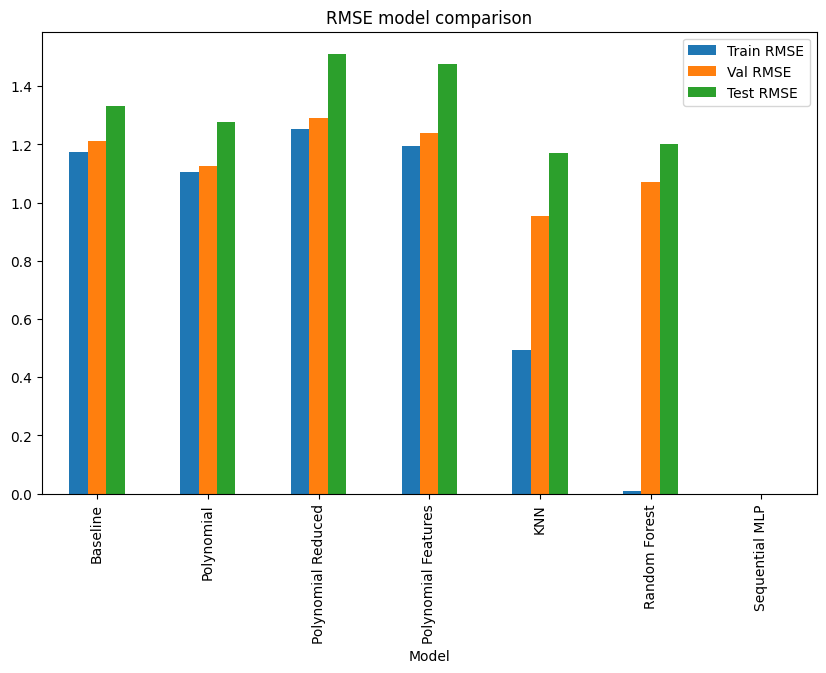

In [115]:
model_comparison.plot(kind='bar', x='Model', y=['Train RMSE', 'Val RMSE', 'Test RMSE'], title="RMSE model comparison", figsize=(10, 6))
plt.savefig('images/model_comparison_rmse.png')

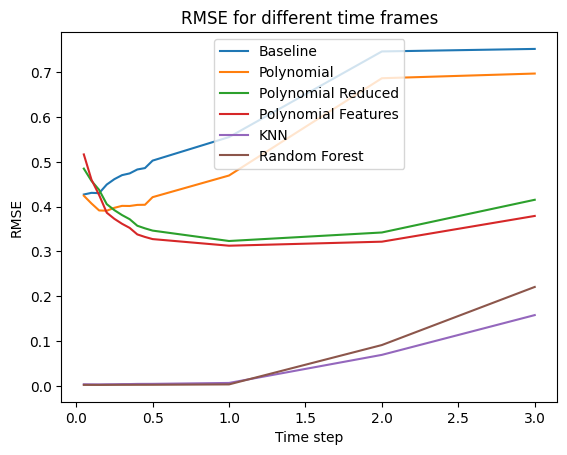

In [96]:
for model_name in model_comparison["Model"].unique():
    if model_name == 'Sequential MLP':
        continue
    rmse_over_time = model_comparison.loc[model_comparison['Model'] == model_name]["RMSE_over_time"].values
    plt.plot(rmse_over_time[0][0], rmse_over_time[0][1], label=model_name)

plt.xlabel('Time step')
plt.ylabel('RMSE')
plt.title('RMSE for different time frames')
plt.legend()
# save fig
plt.savefig('rmse_over_time.png')
plt.show()